In [89]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [145]:
from src.datasources import glofas
from src.datasources import grrr
from src.utils import cds_utils
import cdsapi
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import requests
import ocha_stratus as stratus

GLOFAS_THRESH = 3130
GOOGLE_THRESH = 1212

## GloFAS Monitoring

In [41]:
# We'll get the forecast data from today and the latest available reanalysis data 
# which we assume is from two days ago
today = datetime.now()
two_days_ago = today - timedelta(days=2)

c = cdsapi.Client()

2025-05-28 15:21:54,761 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


In [ ]:
# Get the pixel location
station = glofas.GF_STATIONS['wuroboki']
glofas_lon, glofas_lat = glofas.get_glofas_grid_coords(
    station["lon"], station["lat"]
)
pitch = 0.001
N = glofas_lat + pitch
S = glofas_lat
E = glofas_lon + pitch
W = glofas_lon

In [190]:
# Get the forecast data for Wurobokki
forecast_dataset = "cems-glofas-forecast"
forecast_request = {
    "system_version": ["operational"],
    "hydrological_model": ["lisflood"],
    "product_type": ["control_forecast"],
    "variable": "river_discharge_in_the_last_24_hours",
    "year": [str(today.year)],
    "month": [str(today.month).zfill(2)],
    "day": [str(today.day).zfill(2)],
    "leadtime_hour": [
        "24",
        "48",
        "72",
        "96",
        "120",
    ],
    "data_format": "grib2",
    "download_format": "unarchived",
    "area": [N, W, S, E],
}

forecast_filename = f"glofas_forecast_{today.year}-{str(today.month).zfill(2)}-{str(today.day).zfill(2)}.grib"
forecast_blob_name = (
    f"ds-aa-nga-flooding/raw/glofas/monitoring/{forecast_filename}"
)
cds_utils.download_raw_cds_api_to_blob(
    forecast_dataset,
    forecast_request,
    forecast_blob_name,
    keep_local_copy=True,
)

2025-05-29 10:09:14,546 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-29 10:09:15,402 INFO [2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
INFO:datapi.legacy_api_client:[2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
2025-05-29 10:09:15,403 INFO [2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.int/display/CEMS/GloFAS+-+Known+Issues)
before downloading the dataset.
INFO:datapi.legacy_api_client:[2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.i

86792ce6560cdb8e02ad6b714bbe79c3.grib:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

PosixPath('temp/ds-aa-nga-flooding/raw/glofas/monitoring/glofas_forecast_2025-05-28.grib')

In [149]:
# Get the reanalysis data for Wurobokki
reanalysis_dataset = "cems-glofas-historical"
reanalysis_request = {
    "system_version": ["version_4_0"],
    "hydrological_model": ["lisflood"],
    "product_type": ["intermediate"],
    "variable": ["river_discharge_in_the_last_24_hours"],
    "hyear": [str(two_days_ago.year)],
    "hmonth": [str(two_days_ago.month).zfill(2)],
    "hday": [str(two_days_ago.day).zfill(2)],
    "data_format": "grib2",
    "download_format": "unarchived",
    "area": [N, W, S, E],
}

# NOTE that we're saving the data with the date of MONITORING in the filename, not the date for which it is valid
reanalysis_filename = f"glofas_reanalysis_{today.year}-{str(today.month).zfill(2)}-{str(today.day).zfill(2)}.grib"
reanalysis_blob_name = (
    f"ds-aa-nga-flooding/raw/glofas/monitoring/{reanalysis_filename}"
)
cds_utils.download_raw_cds_api_to_blob(
    reanalysis_dataset,
    reanalysis_request,
    reanalysis_blob_name,
    keep_local_copy=True,
)

2025-05-28 23:19:16,331 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-28 23:19:16,954 INFO [2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
INFO:datapi.legacy_api_client:[2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
2025-05-28 23:19:16,956 INFO [2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.int/display/CEMS/GloFAS+-+Known+Issues)
before downloading the dataset.
INFO:datapi.legacy_api_client:[2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.i

3f6d4f53d16507d072591164831ec208.grib:   0%|          | 0.00/244 [00:00<?, ?B/s]

PosixPath('temp/ds-aa-nga-flooding/raw/glofas/monitoring/glofas_reanalysis_2025-05-28.grib')

In [150]:
ds_reanalysis = xr.open_dataset(
    f"temp/{reanalysis_blob_name}",
    engine="cfgrib",
    decode_timedelta=True,
    backend_kwargs={
        "indexpath": "",
    },
)
ds_forecast = xr.open_dataset(
    f"temp/{forecast_blob_name}",
    engine="cfgrib",
    decode_timedelta=True,
    backend_kwargs={
        "indexpath": "",
    },
)

ds_reanalysis = ds_reanalysis.assign_coords(
    valid_time_start=ds_reanalysis["valid_time"] - pd.Timedelta(hours=24)
)
df_reanalysis = ds_reanalysis.to_dataframe().reset_index()
df_reanalysis["valid_time"] = pd.to_datetime(df_reanalysis["valid_time"])

ds_forecast = ds_forecast.assign_coords(
    valid_time_start=ds_forecast["valid_time"] - pd.Timedelta(hours=24)
)
df_forecast = ds_forecast.to_dataframe().reset_index()
df_forecast["valid_time"] = pd.to_datetime(df_forecast["valid_time"])

In [ ]:
def process_glofas(blob_name, data_type):
    ds = xr.open_dataset(
        f"temp/{blob_name}",
        engine="cfgrib",
        decode_timedelta=True,
        backend_kwargs={
            "indexpath": "",
        },
    )
    df = (
        ds.assign_coords(valid_time=ds["valid_time"] - pd.Timedelta(hours=24))
        .to_dataframe()
        .reset_index()
    )
    df["valid_time"] = pd.to_datetime(df["valid_time"])
    df["src"] = data_type
    df = df.rename(columns={"dis24": "value", "time": "issued_time"})
    return df[["issued_time", "valid_time", "value", "src"]]

In [189]:
process_glofas(forecast_blob_name, "forecast")

,issued_time,valid_time,value,src
0,2025-05-28,2025-05-28,72.12500,forecast
1,2025-05-28,2025-05-29,72.25000,forecast
2,2025-05-28,2025-05-30,72.18750,forecast
3,2025-05-28,2025-05-31,71.96875,forecast
4,2025-05-28,2025-06-01,71.93750,forecast


In [173]:
df_forecast

,step,latitude,longitude,number,time,surface,valid_time,dis24,valid_time_start
0,1 days,9.375,12.775,0,2025-05-28,0.0,2025-05-29,72.12500,2025-05-28
1,2 days,9.375,12.775,0,2025-05-28,0.0,2025-05-30,72.25000,2025-05-29
2,3 days,9.375,12.775,0,2025-05-28,0.0,2025-05-31,72.18750,2025-05-30
3,4 days,9.375,12.775,0,2025-05-28,0.0,2025-06-01,71.96875,2025-05-31
4,5 days,9.375,12.775,0,2025-05-28,0.0,2025-06-02,71.93750,2025-06-01


In [174]:
df

,issuedTime,gaugeId,value,forecastStartTime,forecastEndTime
8,2025-05-29 06:13:11.536864+00:00,hybas_1120842550,74.872849,2025-05-27 00:00:00+00:00,2025-05-28 00:00:00+00:00
9,2025-05-29 06:13:11.536864+00:00,hybas_1120842550,76.126602,2025-05-28 00:00:00+00:00,2025-05-29 00:00:00+00:00
10,2025-05-29 06:13:11.536864+00:00,hybas_1120842550,75.129654,2025-05-29 00:00:00+00:00,2025-05-30 00:00:00+00:00
11,2025-05-29 06:13:11.536864+00:00,hybas_1120842550,76.396683,2025-05-30 00:00:00+00:00,2025-05-31 00:00:00+00:00
12,2025-05-29 06:13:11.536864+00:00,hybas_1120842550,78.914337,2025-05-31 00:00:00+00:00,2025-06-01 00:00:00+00:00
13,2025-05-29 06:13:11.536864+00:00,hybas_1120842550,82.721779,2025-06-01 00:00:00+00:00,2025-06-02 00:00:00+00:00
14,2025-05-29 06:13:11.536864+00:00,hybas_1120842550,85.992416,2025-06-02 00:00:00+00:00,2025-06-03 00:00:00+00:00
15,2025-05-29 06:13:11.536864+00:00,hybas_1120842550,84.327164,2025-06-03 00:00:00+00:00,2025-06-04 00:00:00+00:00


## Google Monitoring

In [151]:
res = requests.get(
    "https://floodforecasting.googleapis.com/v1/gauges:queryGaugeForecasts",
    params={
        "key": grrr.FLOODS_API_KEY,
        "gaugeIds": grrr.HYBAS_ID,
        "issuedTimeStart": today.strftime("%Y-%m-%d"),
    },
).json()

rows = []

for forecast in res["forecasts"][grrr.HYBAS_ID]["forecasts"]:
    issued_time = forecast["issuedTime"]
    gauge_id = forecast["gaugeId"]

    # Process each forecast range
    for range_item in forecast["forecastRanges"]:
        row = {
            "issuedTime": issued_time,
            "gaugeId": gauge_id,
            "value": range_item["value"],
            "forecastStartTime": range_item["forecastStartTime"],
            "forecastEndTime": range_item["forecastEndTime"],
        }
        rows.append(row)

# Create the DataFrame
df = pd.DataFrame(rows)

# Convert string timestamps to datetime objects for easier analysis
df["issuedTime"] = pd.to_datetime(df["issuedTime"])
df["forecastStartTime"] = pd.to_datetime(df["forecastStartTime"])
df["forecastEndTime"] = pd.to_datetime(df["forecastEndTime"])

# In case there are two forecasts, get the latest one
df = df[df.issuedTime == df.issuedTime.max()]

## Check Conditions

In [ ]:
engine = stratus.get_engine(stage="dev")
with engine.connect() as con:
    df = pd.read_sql(
        """
        select * from monitoring.nga_cerf_flooding
        where updated = (select max(updated) from monitoring.nga_cerf_flooding)
        """,
        con=con,
    )

In [196]:
df

,issued_time,value,valid_time,src,updated
0,2025-05-29,72.093750,2025-05-29,glofas_forecast,2025-05-29
1,2025-05-29,72.031250,2025-05-30,glofas_forecast,2025-05-29
2,2025-05-29,71.750000,2025-05-31,glofas_forecast,2025-05-29
3,2025-05-29,71.500000,2025-06-01,glofas_forecast,2025-05-29
4,2025-05-29,71.750000,2025-06-02,glofas_forecast,2025-05-29
5,2025-05-27,71.906250,2025-05-27,glofas_reanalysis,2025-05-29
6,2025-05-29,75.506729,2025-05-28,hybas_1120842550,2025-05-29
7,2025-05-29,78.817406,2025-05-29,hybas_1120842550,2025-05-29
8,2025-05-29,75.932526,2025-05-30,hybas_1120842550,2025-05-29
9,2025-05-29,76.476036,2025-05-31,hybas_1120842550,2025-05-29


In [197]:
df_google = df[df.src.str.contains("hybas")]
df_glofas = df[df.src.str.contains("glofas")]

In [198]:
df_glofas

,issued_time,value,valid_time,src,updated
0,2025-05-29,72.09375,2025-05-29,glofas_forecast,2025-05-29
1,2025-05-29,72.03125,2025-05-30,glofas_forecast,2025-05-29
2,2025-05-29,71.75000,2025-05-31,glofas_forecast,2025-05-29
3,2025-05-29,71.50000,2025-06-01,glofas_forecast,2025-05-29
4,2025-05-29,71.75000,2025-06-02,glofas_forecast,2025-05-29
5,2025-05-27,71.90625,2025-05-27,glofas_reanalysis,2025-05-29


## Create Plot

In [ ]:
ax = ax1
df_forecast = df[df.src.str.contains("forecast")]
df_reanalysis = df[df.src.str.contains("reanalysis")]
exceeds = False
thresh = GLOFAS_THRESH
dataset = "GloFAS"
date = today

####

def forecast_subplot(ax, df_forecast, df_reanalysis, exceeds, thresh, dataset, date)
    ax.plot(
        df_forecast["valid_time"],
        df_forecast["value"],
        marker="o",
        linestyle="-",
        linewidth=2,
        markersize=4,
        label="Forecast",
        color="blue",
        alpha=0.8,
    )

    for i, row in df_forecast.iterrows():
        ax.annotate(
            f'{row["value"]:.1f}',
            (row["valid_time"], row["value"]),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            fontsize=8,
            color="blue",
        )

    # Add horizontal threshold line
    ax.axhline(
        y=thresh,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Trigger Threshold ({thresh})",
        alpha=0.8,
    )

    if isinstance(df_reanalysis, pd.DataFrame):
        ax.plot(
            df_reanalysis["valid_time"],
            df_reanalysis["value"],
            marker="s",
            linestyle="-",
            linewidth=2,
            markersize=6,
            label="Reanalysis",
            color="red",
            alpha=0.8,
        )

        # Add labels for reanalysis points
        for i, row in df_reanalysis.iterrows():
            ax.annotate(
                f'{row["value"]:.1f}',
                (row["valid_time"], row["value"]),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
                fontsize=8,
                color="red",
            )

    title = f"{dataset} Monitoring: {date} | Triggers = {exceeds}"

    ax.set_ylabel("Streamflow", fontsize=12)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

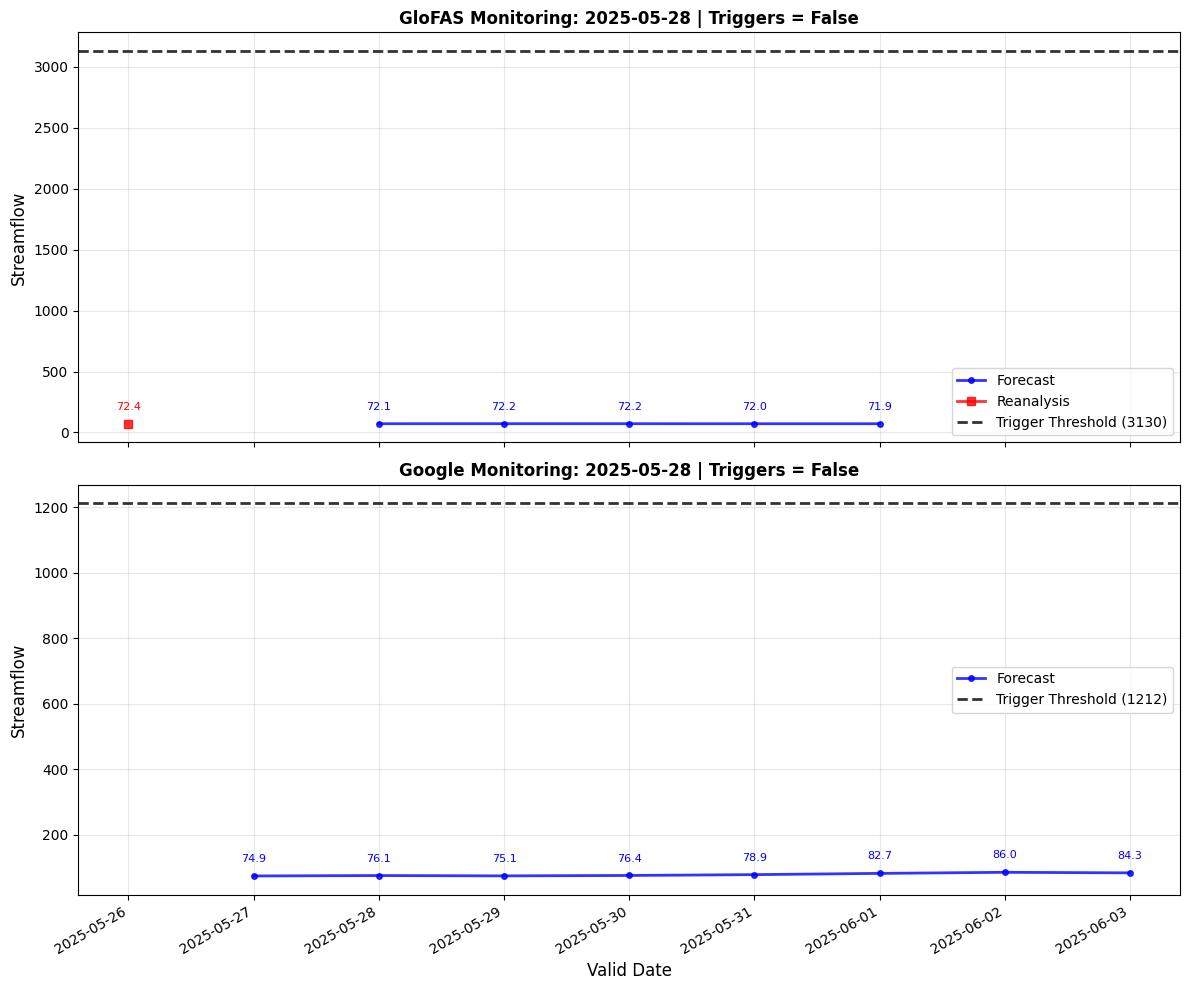

In [171]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# ============ FIRST SUBPLOT - GloFAS Data ============
ax1.plot(
    df_forecast["valid_time_start"],
    df_forecast["dis24"],
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=4,
    label="Forecast",
    color="blue",
    alpha=0.8,
)

for i, row in df_forecast.iterrows():
    ax1.annotate(
        f'{row["dis24"]:.1f}',
        (row["valid_time_start"], row["dis24"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        color="blue",
    )

ax1.plot(
    df_reanalysis["valid_time_start"],
    df_reanalysis["dis24"],
    marker="s",
    linestyle="-",
    linewidth=2,
    markersize=6,
    label="Reanalysis",
    color="red",
    alpha=0.8,
)

# Add labels for reanalysis points
for i, row in df_reanalysis.iterrows():
    ax1.annotate(
        f'{row["dis24"]:.1f}',
        (row["valid_time_start"], row["dis24"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        color="red",
    )

# Check if values exceed threshold and create title
forecast_exceeds = (df_forecast["dis24"] > GLOFAS_THRESH).any()
reanalysis_exceeds = (df_reanalysis["dis24"] > GLOFAS_THRESH).any()

title1 = f"GloFAS Monitoring: {today} | Triggers = {glofas_exceeds}"

# Add horizontal threshold line
ax1.axhline(
    y=GLOFAS_THRESH,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Trigger Threshold ({GLOFAS_THRESH})",
    alpha=0.8,
)

ax1.set_ylabel("Streamflow", fontsize=12)
ax1.set_title(title1, fontsize=12, fontweight="bold")
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# ============ SECOND SUBPLOT - Google Data ============

ax2.plot(
    df["forecastStartTime"],
    df["value"],
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=4,
    label="Forecast",
    color="blue",
    alpha=0.8,
)

for i, row in df.iterrows():
    ax2.annotate(
        f'{row["value"]:.1f}',
        (row["forecastStartTime"], row["value"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        color="blue",
    )

ax2.axhline(
    y=GOOGLE_THRESH,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Trigger Threshold ({GOOGLE_THRESH})",
    alpha=0.8,
)

title2 = f"Google Monitoring: {today} | Triggers = {google_exceeds}"

# Check if values exceed threshold and create title
value_exceeds = (df["value"] > GLOFAS_THRESH).any()

ax2.set_xlabel("Valid Date", fontsize=12)
ax2.set_ylabel("Streamflow", fontsize=12)
ax2.set_title(title2, fontsize=12, fontweight="bold")
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(f"temp/{today}_{overall_exceeds}.png", dpi=300)
plt.show()